In [10]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import pycountry_convert as pcc
import geopandas as gpd
import spacy
from nltk.corpus import stopwords
import re
from collections import Counter
import networkx as nx
from wordcloud import WordCloud

In [9]:
spine_df = pd.read_json('data/criterion_list.json')

boxsets_info_df = pd.read_json('data/criterion_boxsets.json')
single_info_df = pd.read_json('data/criterion_single_movies.json')

info_df = pd.concat([boxsets_info_df, single_info_df], axis=0, ignore_index=True)

df = pd.merge(spine_df, info_df, on='url', how='left')

df.drop(['date_scraped', 'time_scraped'], axis=1, inplace=True)
df.replace('', np.NaN, inplace=True)

del spine_df
del info_df
del boxsets_info_df
del single_info_df

In [14]:
df.head()

,country,director,spine_number,title,url,year_of_release,aspect_ratio,blurb,cast,colour,credits,films_contained,formats,language,run_time,special_features
0,"France,",Jean-Luc Godard,482,2 or 3 Things I Know About Her,https://www.criterion.com/films/1333-2-or-3-th...,1967,2.35:1,In 2 or 3 Things I Know About Her (2 ou 3 chos...,"Marina Vlady, Anny Duperey, Joseph Gerhard, Ro...",Color,Director Jean-Luc Godard Screenplay Jean-Luc G...,NaN,DVD,French,87 minutes,"New, restored high-definition digital transfer..."
1,"United States,",Delmer Daves,657,3:10 to Yuma,https://www.criterion.com/films/27910-3-10-to-...,1957,1.85:1,"In this beautifully shot, psychologically comp...","Glenn Ford, Van Heflin, Felicia Farr, Leora Da...",Black & White,Director Delmer Daves Produced by David Heilwe...,NaN,"Blu-Ray, DVD",English,92 minutes,"New, restored 4K digital film transfer, with u..."
2,,,327,3 Films by Louis Malle,https://www.criterion.com/boxsets/397-3-films-...,,,Few directors have portrayed the agonies and e...,,,,"Au revoir les enfants, Murmur of the Heart, La...",DVD,,NaN,"New, restored high-definition digital transfer..."
3,,,672,3 Films by Roberto Rossellini Starring Ingrid ...,https://www.criterion.com/boxsets/982-3-films-...,,,"In the late 1940s, the incandescent Hollywood ...",,,,"Journey to Italy, Europe '51, Stromboli","Blu-Ray, DVD",,NaN,New digital restorations of the English- and I...
4,,,528,3 Silent Classics by Josef von Sternberg,https://www.criterion.com/boxsets/744-3-silent...,,,"Vienna-born, New York-raised Josef von Sternbe...",,,,"The Docks of New York, The Last Command, Under...",Blu-Ray,,NaN,High-definition digital restorations of all th...


In [15]:
list(df.columns)

['country',
 'director',
 'spine_number',
 'title',
 'url',
 'year_of_release',
 'aspect_ratio',
 'blurb',
 'cast',
 'colour',
 'credits',
 'films_contained',
 'formats',
 'language',
 'run_time',
 'special_features']

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1441 entries, 0 to 1440
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   country           1320 non-null   object
 1   director          1319 non-null   object
 2   spine_number      1071 non-null   object
 3   title             1441 non-null   object
 4   url               1441 non-null   object
 5   year_of_release   1312 non-null   object
 6   aspect_ratio      1314 non-null   object
 7   blurb             1441 non-null   object
 8   cast              1320 non-null   object
 9   colour            1313 non-null   object
 10  credits           1276 non-null   object
 11  films_contained   120 non-null    object
 12  formats           997 non-null    object
 13  language          1306 non-null   object
 14  run_time          1321 non-null   object
 15  special_features  1047 non-null   object
dtypes: object(16)
memory usage: 191.4+ KB


and with that initial view of the data its time to begin the process of cleaning and prepping the data

# Cleaning

I have a feeling that alot of these NULLs will fall into the same few products since 
it looks like the box sets are largely null in the same set of columns. 

**to test this, I will create a NULL heatmap.**

<AxesSubplot:>

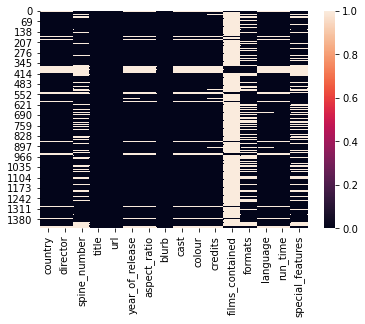

In [20]:
sns.heatmap(df.isnull())

so there are NULLs in spine_number and formats that seem largely unpatterned, whilst NULLs in other
columns appear to frequently fall on the same rows as expected. 

I believe spine number NULLs are very likely to be exclusively movies who appear in box sets rather than individually

next for the sake of QAing the data I'd like to look at some unique values

In [21]:
df.describe()

,country,director,spine_number,title,url,year_of_release,aspect_ratio,blurb,cast,colour,credits,films_contained,formats,language,run_time,special_features
count,1320,1319,1071,1441,1441,1312,1314,1441,1320,1313,1276,120,997,1306,1321,1047
unique,46,526,1070,1433,1441,97,34,1436,1311,10,1273,120,9,98,169,1040
top,"United States,",Ingmar Bergman,88,The Killers,https://www.criterion.com/boxsets/427-eclipse-...,1966,1.33:1,"Jean Renoir and Akira Kurosawa, two of cinema'...",Director,Color,Director Vilgot Sjoman Producer Goran Lindgren...,"Kings of the Road, Alice in the Cities, Wrong ...","Blu-Ray, DVD",English,96 minutes,"New digital transfer of The Emperor Jones, cre..."
freq,405,41,2,3,1,40,394,3,6,695,2,1,654,528,41,2


standing out to me here are:
- **colour** as i can't guess what other than colour or B&W could be options here
- **formats** as other than DVD and BluRay what formats are there
- **language** as i wasnt aware there existed 98 languages
- country 
- aspect_ratio 
- year_of_release


**Colour**

In [22]:
list(df.colour.unique())

['Color',
 'Black & White',
 nan,
 'Black and White/Color',
 '1.37:1',
 '2.35:1',
 '1.33:1',
 '1.85:1',
 '1.66:1',
 '1.33:1/1.78:1',
 '1.78:1']

bro those is aspect ratios!!

from further investigation I have come up with the following method of cleaning the fuzziness surrounding certain columns:
- in cases where colour or langauge are in aspect_ratio, these values are moved into their correct columns
- in cases where aspect ratio is in colour this is moved into aspect_ratio, and then the colour is set to NaN as it is not salvageable
- in cases where colour is stored in run_time this is moved into colour and then run_time is set to NaN
- in cases where language contains spine number this is replaced with NaN
- in cases where language contains aspect_ratio this is moved into aspect ratio then lanuage is set to NaN
- cases where aspect ratio still isnt a true aspect ratio value are then set to NaN
- single films are set to contain themselves.

In [10]:
colour_asp = list(df[(df.aspect_ratio.isin(['Black & White', 'Color']))].index)
lang_asp = list(df[(df.aspect_ratio.str.contains('[a-z]') == True) & (~df.aspect_ratio.isin(['Black & White', 'Color']))].index)

df.loc[df.index.isin(colour_asp), 'colour'] = df.loc[df.index.isin(colour_asp), 'aspect_ratio']
df.loc[df.index.isin(lang_asp), 'language'] = df.loc[df.index.isin(lang_asp), 'aspect_ratio']

df.loc[df.colour.str.contains('[a-z]') == False, 'aspect_ratio'] = df.loc[df.colour.str.contains('[a-z]') == False, 'colour']
df.loc[df.colour.str.contains('[a-z]') == False, 'colour'] = np.nan

df.loc[df.run_time.str.contains('[0-9]') == False, 'colour'] = df.loc[df.run_time.str.contains('[0-9]') == False, 'run_time']
df.loc[df.run_time.str.contains('[0-9]') == False, 'run_time'] = np.nan

df.loc[~df.language.isnull() & df.language.str.contains('Spine #'), 'language'] = np.nan
df.loc[df.language.str.contains('[a-z]') == False, 'aspect_ratio'] = df.loc[df.language.str.contains('[a-z]') == False, 'language']
df.loc[df.language.str.contains('[a-z]') == False, 'language'] = np.nan

df.loc[df.aspect_ratio.str.contains('[0-9]') == False, 'aspect_ratio'] = np.nan

df.loc[df.films_contained.isna(), 'films_contained'] = df.title

now every cell contains the correct value, so its time to start doing some cleaning

for now this is very basic but might do some more later i dunno

SPOILER - came back and remembered this weeks later, I did not do some more hahaha

In [11]:
df.run_time = df.run_time.str.replace(' minutes', '').astype('float')

df.country = df.country.str.replace(',', '')

**Feature Creation**

next up we'll be doing some basic feature creation. initially I will focus on just some basic useful binaries that might be of use:


In [12]:
df['decade_of_release'] = df['year_of_release'].str[:3] + '0'

df['dvd'] =  np.where(df['formats'].str.contains('DVD', na=False), 1, 0)
df['bluray'] = np.where(df['formats'].str.contains('Blu-Ray', na=False), 1, 0)

df['english'] = np.where(df['language'].str.contains('English', na=False), 1, 0)

df['boxset'] = np.where(df['url'].str.contains('boxset', na=False), 1, 0)

df['available_individually'] = np.select([(df['boxset'] == 0) & (df['spine_number'].isna()),
                                          (df['boxset'] == 0) & (~df['spine_number'].isna())],
                                         [0, 1], default=np.nan)  # set nan where boxsets occur

next just because i can as much as anything I'd like to create a 'sets included in' variable, listing any boxsets a given film is contained within. This will be set to NaN for films only available as single releases / boxsets

the following method is not the msot readable, but is alot faster than the alternative I was using before that just utilised loops. thanks to this thread:
https://stackoverflow.com/questions/53342715/pandas-dataframe-select-rows-where-a-list-column-contains-any-of-a-list-of-strin
for providing the basis for the code

In [13]:
def get_boxsets_contained_in(
    title,
    boxsets,
):
    """Function that gets the boxsets a given film is included in, or returns nan if its not in any.
    
    Parameters
    ----------
    title : string
        The title of the movie.
    boxsets : pd.DataFrame
        Dataframe containing two columns: 'title' and 'films_contained'. The latter of these takes
        values of lists whilst the former takes string.
                    
    Returns
    -------
    string / np.NaN
        String of comma separated boxsets if film is contained in at least one, else np.NaN.
    """
    boxsets_contained_in = boxsets[pd.DataFrame(boxsets.films_contained.tolist())
                                     .isin([title]).values]['title'].values.tolist()      
    # ^^ this method is used to pull up a list of all titles from boxsets where films_contained 
    # contains title. the list will exist but be empty if none exist.
        
    if len(boxsets_contained_in) > 0:
        return ', '.join(boxsets_contained_in)
    
    else: 
        return np.nan
    
    
boxsets = df[df['boxset'] == 1][['title', 'films_contained']].copy().reset_index()
boxsets['films_contained'] = boxsets['films_contained'].str.split(',')

df['boxsets_contained_in'] = df.apply(lambda x: get_boxsets_contained_in(x['title'], boxsets), axis=1)
df['included_in_boxset'] = np.where(df['boxsets_contained_in'].isna(), 0, 1)

next off ive noticed some boxsets which have the director in the title / all movies are by the same person but whos 'director' variable is NULL. same would hold for country I'd guess. this should get rectified lads.

the code bellow could be a bit fluffy, since there are around forty directors who aparently hail from multiple countries. for the sake of the join I've opted to just take the first country they were associated too but there might be a better way of doing this (prehaps take the country they were associated too during the film via its original country of origin?)

In [14]:
def get_director_from_title(
    directors_lst,
    title,
    boxset_director,
):
    """Function gets the director from the boxsets title, if it is contained within.
    
    Parameters
    ----------
    directors_lst : list
        List of directors present in the data.
    title : string
        Title of the boxset in question.
    boxset_director : string / np.NaN
        Current name of director.
        
    Returns
    -------
    string / np.NaN
        Either returns a directors name, or a NaN obj 
    """
    if pd.isna(boxset_director):
        for director in directors_lst:
            if director in title:
                boxset_director = director
    
    return boxset_director


directors = df['director'].dropna().unique().tolist()
df['director'] = df.apply(lambda x: get_director_from_title(directors, x['title'], x['director']), axis=1)

countrys = df[['director', 'country']].dropna().drop_duplicates(subset=['director'], keep='first')
countrys.columns = ['director', 'country_2']

df = pd.merge(df, countrys, on='director', how='left')

df['country'] = df['country'].fillna(df['country_2'])
df.drop('country_2', axis=1, inplace=True)

Next up I think all those countries of origin might be hard to manage initially, so adding continent would go down a treat.

I've had to make some substitutions to get the pycountry_convert package to work since I'd still rather use that then look for a more complete dataset. The only controversial one really is Yugoslavia which has actually been split up into many countries since. since all these new countries exist in europe anyways and we've only done this to get continent as a variable however i see no issue in just taking serbia as its country. 

whilst continent code would be enough for me to go off usually, the code 'NA' will be read in as a NULL value if you don't already know to filter it during the read in so for the sake of me not getting clumsy I've opted to replace the codes with the actual continents, done via a merge rather than a replace here for unknown reasons.

In [15]:
df['country_code'] = df.apply(lambda x: pcc.country_name_to_country_alpha2(x['country']\
                                                                           .replace('Soviet Union', 'Russia')\
                                                                           .replace('West ', '')\
                                                                           .replace('Czechoslovakia', 'Czechia')\
                                                                           .replace('Yugoslavia', 'Serbia'),
                                                                           cn_name_format="default")
                              if(pd.notnull(x['country'])) else np.nan, axis=1)

df['continent_code'] = df.apply(lambda x: pcc.country_alpha2_to_continent_code(x['country_code'])
                                if(pd.notnull(x['country_code'])) else np.nan, axis=1)

continents = pd.DataFrame([['EU', 'Europe'],
                           ['NA', 'North America'],
                           ['AS', 'Asia'],
                           ['OC', 'Oceania'],
                           ['AF', 'Africa'],
                           ['SA', 'South America']],
                         columns=['continent_code', 'continent'])

df = pd.merge(df, continents, on='continent_code', how='left')
df.drop('country_code', axis=1, inplace=True)
df.drop('continent_code', axis=1, inplace=True)

**Adding additional review data**

I was hoping to get some user scores for the films themselves but its been next to impossible to track down either a dataset or a website that houses scores for old, hipster movies like half of these. instead I've gone with a website i found called criterionforum which had a section for reviews. 

the resultant data has no review of film quality, only picture, audio and extras which i guess is to be expected given the nature of the product in question. 

despite the sites name, it also seems to house reviews for other boutique bluray companies products such as 'arrow'. for now i wont use this information, but might be worth something later on?

the site has a section for films whose names start with numbers which is unfortunately not accessible so all those movies are missed, i.e. the data is only movies who begin with letters a-z.

The site appears to be someones hobby so likely does not give total coverage of the collection. a view of the heatmap bellow confirms this. its still better than nothing though... right?

as a final caveat for this data the guy who does the reviews actually reviews the same film multiple times for each available format, leading to cases of two or even three rows for a single film. I'm not too sure how I want to handle this going forwards but for now I'll take the most recent releases' data. 

all that for some heavily biased review scores lol. ive attached it to the data either way hopefully some good comes of it

In [16]:
reviews_df = pd.read_json('data/boutique_bluray_reviews.json')

reviews_df.drop(['date_scraped', 'time_scraped', 'scores', 'company'], axis=1, inplace=True)

reviews_df['year_of_disk_release'] = reviews_df['year_of_disk_release'].str.replace(')', '')
reviews_df['decade_of_disk_release'] = reviews_df['year_of_disk_release'].str[:3] + '0' 
reviews_df['year_of_disk_release'] = reviews_df['year_of_disk_release'].astype(int)

most_recent_reviews_df = reviews_df.loc[reviews_df.groupby('title')['year_of_disk_release'].idxmax()]

df = pd.merge(df, most_recent_reviews_df, on='title', how='left')

I'll now replot the null heatmap to see how these new variables are behaving in their rawest form

<AxesSubplot:>

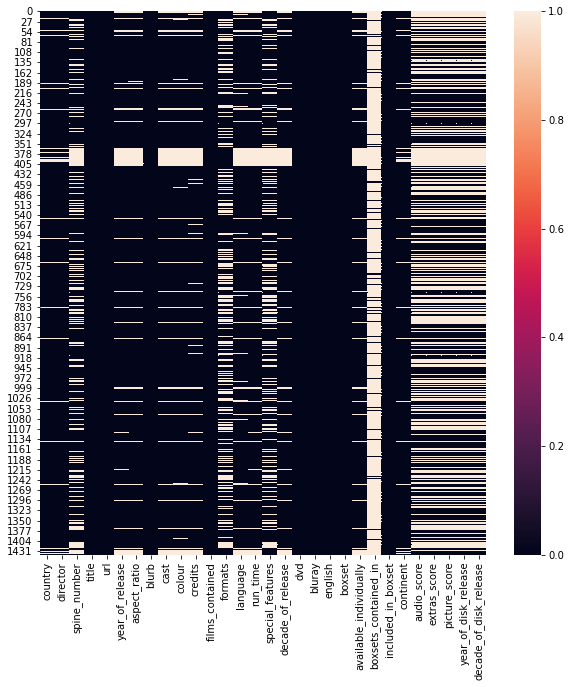

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data=df.isna(), ax=ax)

the huge chunk of nulls which is also null for the review score data is kind of curious?
other than that all looking good though i think...

now time to move on to some plots i think:

# EDA


**bar charts**

here, I just want the most basic shape info on some of these variables, starting with some count plots
hopefully this will start to form a picture of what the data actually is

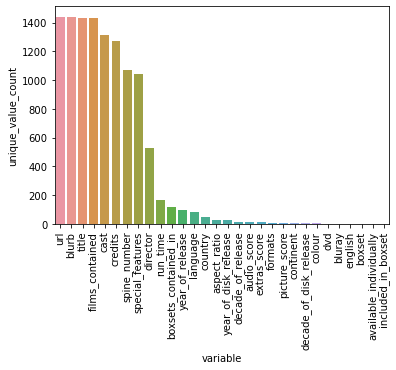

In [18]:
### unique value counts visualised ###

unique_vals = df.nunique().reset_index().sort_values(by=0, ascending=False)
unique_vals.columns = ['variable', 'unique_value_count']

sns.barplot(x='variable',
            y='unique_value_count',
            data=unique_vals)
plt.xticks(rotation=90)
plt.show()

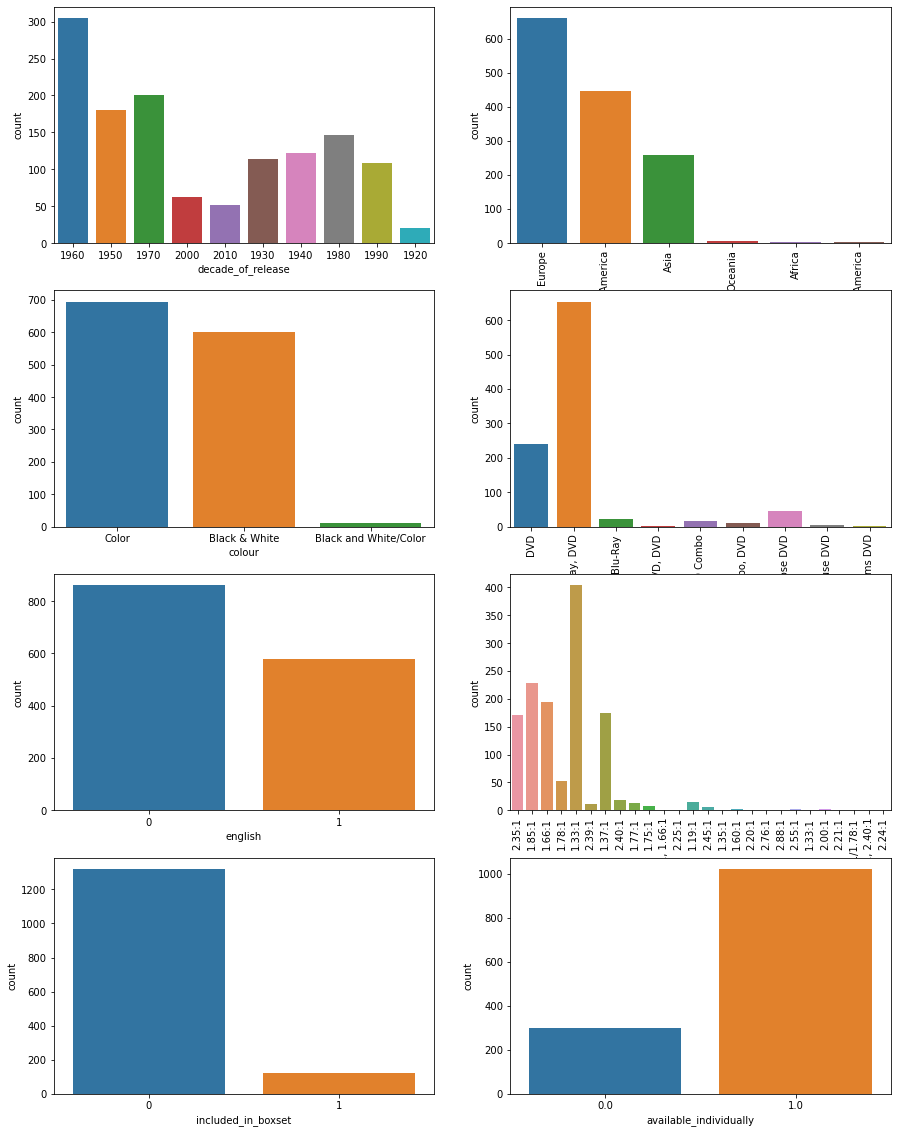

In [19]:
### value count plots for some arbitrary vars ###

count_plot_cols = [('decade_of_release', [0, 0]), 
                   ('continent', [0, 1]),
                   ('colour', [1, 0]),
                   ('formats', [1, 1]),
                   ('english', [2, 0]),
                   ('aspect_ratio', [2, 1]),
                   ('included_in_boxset', [3, 0]),
                   ('available_individually', [3, 1])]

fig, ax = plt.subplots(4, 2, figsize=(15, 20))

for col_tuple in count_plot_cols:
    sns.countplot(x=col_tuple[0], data=df,
                  ax=ax[col_tuple[1][0], col_tuple[1][1]])

for i in range(0, 3):
    plt.setp(ax[i, 1].xaxis.get_majorticklabels(), rotation=90)

plt.show()

a few initial insites:
- nice normal curve on decade of release
- wasnt expecting anything to be both black and white and colour really, wonder what films they are?
- interestingly very few films are solely on blu ray
- would be nice if I could read the axis hahaha
- there are a large number of aspect ratios that are basically unused
- 300 movies arent available individually. this is fewer than were included in boxsets...? something isnt adding up here there must be more movies with a null valued spine number who arent boxsets than i realised?
- of the movies with language data available, there are more without enlish than with

Now I'll have a quick look at what can be learnt from those review scores I added on earlier with a stacked bar plot for percentage of rows per score:

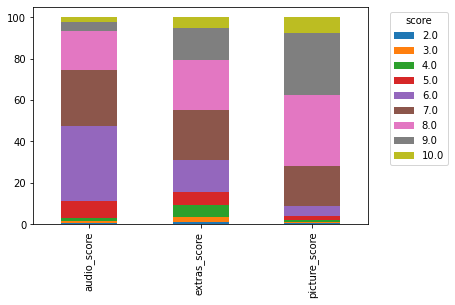

In [56]:
scores = df[[col for col in df.columns if 'score' in col]].dropna()
scores = [pd.DataFrame(scores[col].value_counts()).reset_index() for col in scores.columns]
scores =  reduce(lambda left, right: pd.merge(left, right, on='index'), scores)
scores.set_index('index', inplace=True)

for col in scores.columns:
    scores[col] = (scores[col] / scores[col].sum()) * 100
        
scores = scores.transpose()
scores = scores.reindex(sorted(scores.columns), axis=1)

scores.plot(kind='bar', stacked=True)
plt.legend(title='score', bbox_to_anchor=(1.05, 1), loc='upper left')

the difference in quality between picture score and audio score is quite stark, but on its own doesn't really tell us that much. Is the audio score a review of the audio quality? The inclusion of things like surround sound? The films score may even factor in. Picture I assume is likely to be to do with the quality of the restoration to blu ray, although again, does the inventiveness of the visuals play a part in this score? Its pretty hard to tell. Even the extras score could be a review of either the quantity, quality or both. overall then I'd say we've learnt basically nothing from this extra data and I regret taking the time out of my day to scrape it hahaha.

Next up, I'll have a look at how runtime behaves for a number of arbitrarily decided groupings, through use of a violin plot:

**Violins**

<AxesSubplot:xlabel='decade_of_release', ylabel='run_time'>

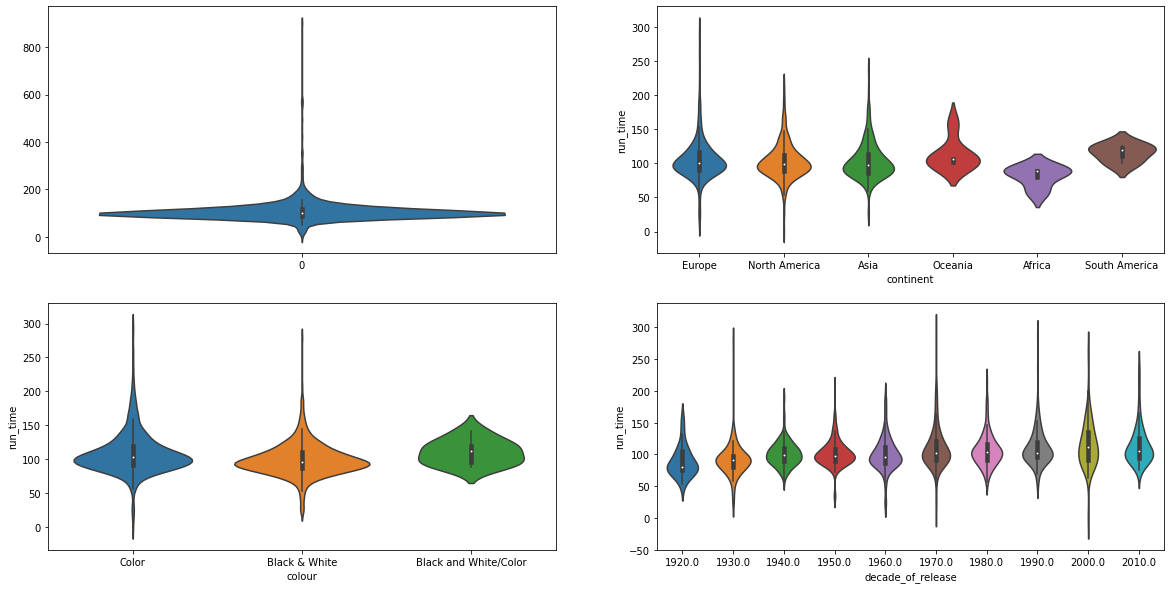

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

sns.violinplot(data=df.run_time, ax=ax[0, 0])
sns.violinplot(x='continent', y='run_time', data=df[df['run_time'] < 300], ax=ax[0, 1])
sns.violinplot(x='colour', y='run_time', data=df[df['run_time'] < 300], ax=ax[1, 0])
sns.violinplot(x='decade_of_release', y='run_time', data=df[df['run_time'] < 300], ax=ax[1, 1])


oh shit man theres a film that looks to be like close to 15 hours long? how? why? I filtered a vague idea of outliers out and plotted what was left. Might be worth coming back and more formally defining the threshold using z score or something if this is an important feature later on. I think you can in the colour and decade of release plot see a general trend towards longer runtimes over time, though not considerable. Continent wise however we see the three continents with a meaningful number of films match up almost exactly which I guess is interesting in its own right.

**Line Graphs**

I'll try some basic line graphs next:

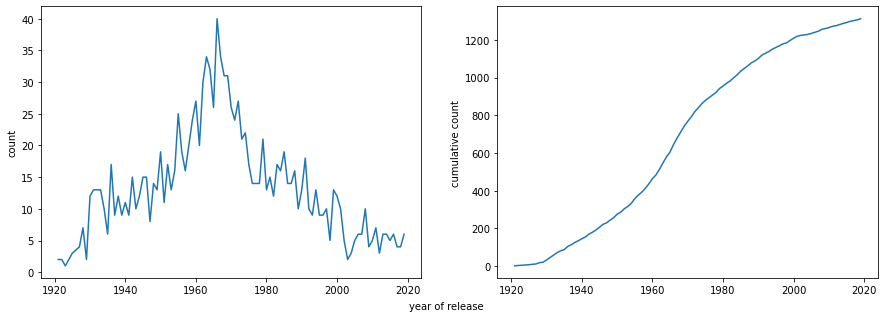

In [40]:
### basic line graphs for counts of releases per year ###

year_of_release_counts = pd.DataFrame(df.groupby('year_of_release').count()['country'])
year_of_release_counts.reset_index(inplace=True)
year_of_release_counts.columns = ['year_of_release', 'count']
year_of_release_counts['cumulative_count'] = year_of_release_counts['count'].cumsum()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot('year_of_release', 'count', data=year_of_release_counts)
ax[0].set_ylabel('count')

ax[1].plot('year_of_release', 'cumulative_count', data=year_of_release_counts)
ax[1].set_ylabel('cumulative count')

fig.text(0.5, 0.04, 'year of release', ha='center')

plt.show()

these are basic count plots for number of films released over time, again showing the general trend toward 1960's that we saw in the bar chat before. in all honesty not much has been gained from this but ack well guess its here now. wouldnt mind prehaps producing plot one again, but this time with separate lines for each value of certain variables (continent and colour jump out to me as semi interesting)

something that I have noted as a bit weird is that the count of films per year is very low for 1990 - present. I'm a normie bitch so most of my favourite films and directors in the collection are from that period, alot of whom have multiple films in covered by the collection. I'd guess from this that with more modern releases they tend to release alot from individual directors rather than as much diversity prehaps? 

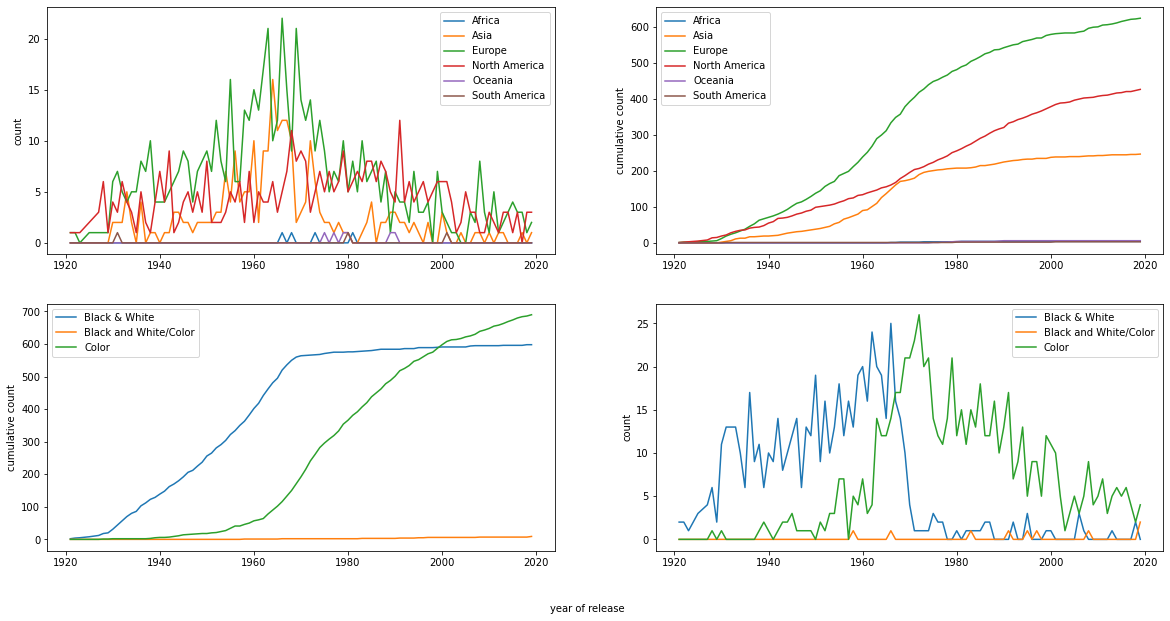

In [41]:
### multiline time series for certain columns ###

year_continent_counts = pd.pivot_table(df, values='title', index='year_of_release', columns='continent', 
                                      aggfunc=pd.Series.nunique, fill_value=0)
year_continent_cum_counts = year_continent_counts.cumsum()

year_colour_counts = pd.pivot_table(df, values='title', index='year_of_release', columns='colour', 
                                      aggfunc=pd.Series.nunique, fill_value=0)
year_colour_cum_counts = year_colour_counts.cumsum()

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

lines = ax[0, 0].plot(year_continent_counts)
ax[0, 0].set_ylabel('count')
ax[0, 0].legend(lines, sorted(df.continent.dropna().unique()))

lines = ax[0, 1].plot(year_continent_cum_counts)
ax[0, 1].set_ylabel('cumulative count')
ax[0, 1].legend(lines, sorted(df.continent.dropna().unique()))

lines = ax[1, 1].plot(year_colour_counts)
ax[1, 1].set_ylabel('count')
ax[1, 1].legend(lines, sorted(df.colour.dropna().unique()))

lines = ax[1, 0].plot(year_colour_cum_counts)
ax[1, 0].set_ylabel('cumulative count')
ax[1, 0].legend(lines, sorted(df.colour.dropna().unique()))

fig.text(0.5, 0.04, 'year of release', ha='center')

plt.show()

I'm not convinced by this one - the value counts graph for continent had correct numbers which dont appear to line up with the cumulative sum graph, in particular for Asia and North America. colour looks about right though. 

that aside the code is quite ugly, surely they can be to some extent automated?

- black and white just drops off around the 70's which is kind of interesting i guess.
- its no longer here but i originally tried plotting the cumulative graphs based on unique spine number count and found asia had way less movies than it does with title, i guess this suggests some large proportion of asian films in the collection are only available via boxset?

**Release Country Chloropleth plot**

Next I want to do some spatial analysis just because its been a while and I fancy it. first, lets go with number of unique titles released per country.

In [24]:
countries_polygons = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries_polygons.drop(['pop_est', 'gdp_md_est'], axis=1, inplace=True)

movies_by_country = df[['title', 'country']].groupby('country').count().reset_index()
countries_poly = countries_polygons.name.unique().tolist()
countries_data = movies_by_country.country.unique().tolist()

missing_polys = [country for country in countries_data if country not in countries_poly]
print(len(missing_polys))
print(missing_polys[:10])

6
['Czechoslovakia', 'Hong Kong', 'Soviet Union', 'United States', 'West Germany', 'Yugoslavia']


so a few of the desolved countries, the USSR, the USA and Hong Kong are all missing polygons. I'll have to replace them in movies_by_country with their closest equivalents who have a polygon available.

In [26]:
movies_by_country.loc[movies_by_country.country == 'Czechoslovakia', 'country'] = 'Czechia'
movies_by_country.loc[movies_by_country.country == 'West Germany', 'country'] = 'Germany'
movies_by_country.loc[movies_by_country.country == 'Yugoslavia', 'country'] = 'Serbia'
movies_by_country.loc[movies_by_country.country == 'Hong Kong', 'country'] = 'China'
movies_by_country.loc[movies_by_country.country == 'United States', 'country'] = 'United States of America'
movies_by_country.loc[movies_by_country.country == 'Soviet Union', 'country'] = 'Russia'

There are some political hotakes in that code, but its just what needs to be done to get the data we have to match that of the available polygons. we can now join the data on to the gpdf and make a chloropleth plot.

nice to see these polygons would've given us the continents anyways without all that damn fiddling hahaha.

for now, We'll be binning the value of criterion_count. this is simply done because otherwise US will completely dominante the map and leave everything else blank (it has over 400 unique titles attached!)

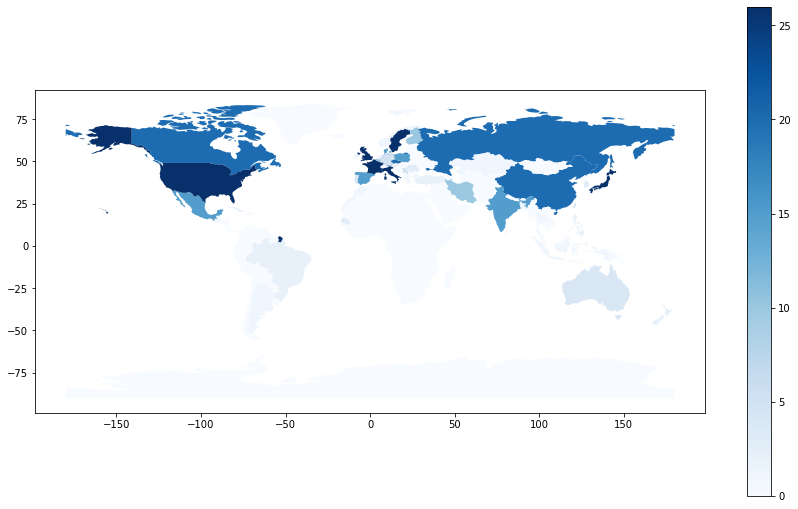

In [27]:
movies_by_country.columns = ['name', 'criterion_release_count']
movies_by_country = pd.merge(movies_by_country, countries_polygons, 
                             on='name', how='outer')
movies_by_country.criterion_release_count.fillna(0, inplace=True)
movies_by_country = gpd.GeoDataFrame(movies_by_country)

bins = [0, 0.5, 1, 2, 3, 4, 5, 10, 15, 20, 25, float('inf')]
labels = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 26]
movies_by_country['criterion_release_count_binned'] = pd.cut(movies_by_country['criterion_release_count'], 
                                  bins=bins, labels=labels)

movies_by_country.criterion_release_count_binned.fillna(0, inplace=True)

ax = movies_by_country.plot(column='criterion_release_count_binned', 
                            cmap = 'Blues', figsize=(15, 9),   
                            legend=True)

other than emphasising that Asias continent dominance is driven seemingy mostly by Japan this doesnt honestly tell us all that much we didn't already know. It is interesting however to see the loss of almost all of the african continent, along with large parts of South America I guess. I also don't think I was expecting Sweeden to show up as darkly as it does here.

Other than directors by country I'm not too sure how much use further spatial analysis might serve in all honesty...


# Natural Language Stuff

I've not done much NLP before but i think the free text descriptions is a good oportunity to try some stuff out. It will probably be embaressingly rudimentary but ack well all about the learning process isnt it.

For my first trick I will reduce the blurb to a list of lemmatised tokens. Tadah!:

In [28]:
def remove_words_from_string(
    text,
    stop_words,
):
    """Remove each of a list of stop words from a larger text.
    
    Parameters
    ----------
    text : string
        The text to be purged of the stop words.
    stop_words : list
        List of words to be purged from the text.
    
    Returns
    -------
    string
        Text, but with stop words removed
    """
    for word in stop_words:
        text = text.replace(' ' + str(word) + ' ', ' ')
    
    return text


def lemmatise_document(
    director_name,
    films_contained,
    blurb,
    stop_words,
):
    """Function to take film blurb, remove all references to director and movie title, 
    remove stop words and then lemmatise.
    
    Parameters
    ----------
    director_name : string
        Name of films director, or np.NaN if not available.
    films_contained : list
        List of strings describing the films contained in a boxset, or just the name of 
        the film if not a boxset.
    blurb : string
        text description of the movie / the release. This will be lemmatised.
    stop_words : list
        List of stop words to be removed from the lemmatised list.
        
    Returns
    -------
    string
        comma separated list of lemmatised tokens.
    """
    stop_words.append(director_name)
    stop_words += films_contained.split(',')
    
    blurb = remove_words_from_string(blurb, stop_words[::-1])
    blurb = re.sub(r'[0-9]+', '', re.sub(r'[^\w]', ' ', blurb))  # remove numbers / punctuation
    
    tokens = sp(blurb)
    lemmatised_blurb = [str(word.lemma_) for word in tokens]
    lemmatised_blurb = [
        word for word in lemmatised_blurb
        if word not in ['  ', ' ', '-PRON-', 's']
    ]
    lemmatised_blurb = ', '.join(lemmatised_blurb)
    
    return lemmatised_blurb
    
    
sp = spacy.load('C:/Users/johnc/Anaconda3/Lib/site-packages/en_core_web_sm/en_core_web_sm-2.3.1')
# cannot get it to import with just the file name so used the full path... :(

stop_words = stopwords.words('english')

df['blurb_lemmas'] = df.apply(
    lambda x: lemmatise_document(x['director'], x['films_contained'], x['blurb'], stop_words), axis=1
)


df[['blurb', 'blurb_lemmas']][:5]

,blurb,blurb_lemmas
0,In 2 or 3 Things I Know About Her (2 ou 3 chos...,"in, ou, chose, que, je, sais, d, elle, beckon,..."
1,"In this beautifully shot, psychologically comp...","in, beautifully, shoot, psychologically, compl..."
2,Few directors have portrayed the agonies and e...,"few, director, portray, agony, epiphanie, grow..."
3,"In the late 1940s, the incandescent Hollywood ...","in, late, incandescent, Hollywood, star, Ingri..."
4,"Vienna-born, New York-raised Josef von Sternbe...","Vienna, bear, New, York, raise, direct, influe..."


I've opted to lemmatise since i might need the text in future and it'll be easier if its in legible English. That said I'm somewhat supprised that lemmatisation isnt able to correctly identify things like 'New York' as being a single noun.

Though initially I'd hoped to do some TF/IDF work here looking at the values we get out of some arbitrary examples gives me second thoughts on the usefullness of that - it seems like they've gone out of their way to avoid using the same word more than twice at all costs hahaha. Prehaps if we get a set of popular words across the entire document first we can do something meaningful here?

I guess developing some kind of dictionary of important meaningful words for film in general might go some way toward helping to classify with the lemmas...?

It migth be cool to also get a feel for how the films are linked using words - maybe some kind of graph can be built?

I dunno, to carry on with the work though lets start by getting an idea of the popularity of the various lemmas...:

In [29]:
all_lemmas = df.blurb_lemmas.tolist()
all_lemmas = ', '.join(all_lemmas).split(',')
all_lemmas = [lemma.strip().lower() for lemma in all_lemmas
             if lemma not in stop_words]

lemma_counts = {}

for lemma in list(set(all_lemmas)):
    lemma_counts[lemma] = all_lemmas.count(lemma)

lemma_counts = pd.DataFrame(lemma_counts.items())
lemma_counts.columns = ['lemma', 'count']

lemma_counts.describe()

,count
count,14544.000000
mean,6.277021
std,22.301801
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,1179.000000


ok so lots to go on here, to break it down:
 - 14.5k unique lemmas is initially daunting
 - nearly 12k of these are present in 4 or fewer descriptions so thats less of a concern
 - the most popular lemma is present in like just <10% of all films, I'd guess at it being something silly like the word 'film'

In [30]:
lemma_counts.sort_values(by='count', ascending=False, inplace=True)
lemma_counts.head(5)

,lemma,count
10982,film,1179
13125,the,799
1717,one,653
2426,director,491
8887,a,482


...yeah... tits... never more frustrated to be dead on the money hahaha
<br>OK so why is 'the' still here when surely its a stop word? and surely 'a' is too... other than this I'd actually say most of these more popular ones are unhelpful so to speak hahaha. Plan of attack then:
 - remove the most common and therefore useless words in the lemma list
 - see whats left
 - if it still looks shit consider building / finding a 'film words' dictionary and seeing what power that has...?

<AxesSubplot:xlabel='order of popularity', ylabel='number of uses in corpus'>

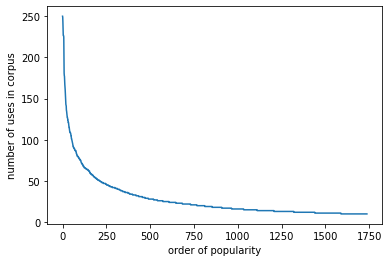

In [31]:
most_common_words = tuple(open('data/most_common_words.txt', 'r'))  # random list I found online, seems legit though
most_common_words = [word.replace('\n', '') for word in most_common_words]

lemma_counts = lemma_counts[~lemma_counts['lemma'].isin(most_common_words)]
lemma_counts = lemma_counts[lemma_counts['count'].between(10, 250)]  

lemma_counts.reset_index().plot.line(y='count',
                                     xlabel='order of popularity',
                                     ylabel='number of uses in corpus',
                                     legend=False)

At this point I moved the data to excel and manually created a binary column for it, where I used a value of 1 to mark words I thought were relevant to the project and left the rest as 0. I hoped this would allow me to create a meaningful dictionary of 'film relevant' words to further this investigation with rather than getting bogged down with words that just hold no real meaning in context.

I have also added an extra column title 'category' where I have attemoted to group similarly themed words into a common title for all the cases where include_word is equal to 1. Since its me this is unlikely to be 100% accurate but its better than nothing at all.

In [32]:
lemma_counts = pd.read_excel('data/lemma_counts.xlsx')

lemma_counts = lemma_counts[lemma_counts['include_word']==1]

filtered_lemmas = lemma_counts.lemma.tolist()

print(lemma_counts.shape)
lemma_counts.head(10)

(466, 4)


,lemma,count,include_word,category
0,war,178,1,war
1,family,177,1,family
2,portrait,150,1,character study
3,comedy,143,1,comedy
4,drama,141,1,drama
5,french,128,1,international
6,classic,121,1,classic
7,hollywood,119,1,classic
8,shoot,115,1,action
9,century,113,1,period


so I'm not convinced I was fully accurate with the labelling but at least its something hahaha. I think prehaps a 'most popular lemma' column and a 'Johns poxy selected lemmas' column might be worth investigating...

In [33]:
def find_filtered_lemmas(
    lemma_list,
    filtered_lemmas_list
):
    """Find which lemmas from one string are in a list.
    
    Parameters
    ----------
    lemma_list : string
        Deceptively named no?
    filltered_lemma_list : list
        List of lemmas to look for.
        
    Returns
    -------
    string
        Comma separated string of filtered lemmas that are in lemma list.
    """
    lemma_list = lemma_list.split(',')
    lemma_list = [lemma.strip().lower() for lemma in lemma_list]
    
    included_filtered_lemmas = [lemma for lemma in lemma_list 
                               if lemma in filtered_lemmas_list]
    included_filtered_lemmas = ', '.join(included_filtered_lemmas)
    
    return included_filtered_lemmas


def most_popular_lemma(
    included_filtered_lemmas,
    ordered_lemmas,
    ignored_lemmas=[],
):
    """Find the most common of the lemmas included in included_filtered_lemmas.
    
    Parameters
    ----------
    included_filtered_lemmas : string
        Comma separated string of lemmas
    ordered_lemmas : list
        Ordered list of lemmas based on popularity.
    ignored_lemmas : list
        List of lemmas not to return no matter what lad.
        
    Returns
    -------
    string
        The most popular of the included lemmas.
    """
    included_filtered_lemmas = included_filtered_lemmas.replace(' ', '').split(',')
    for lemma in ordered_lemmas:
        if lemma in included_filtered_lemmas and lemma not in ignored_lemmas:
            return lemma


df['filtered_lemmas'] =  df.apply(lambda x: find_filtered_lemmas(x['blurb_lemmas'], filtered_lemmas), axis=1)
df['most_common_lemma'] = df.apply(lambda x: most_popular_lemma(x['filtered_lemmas'], filtered_lemmas), axis=1)
df['sm_common_lemma'] = df.apply(
    lambda x: most_popular_lemma(x['filtered_lemmas'], filtered_lemmas, [x['most_common_lemma']]), axis=1
)
df['tm_common_lemma'] = df.apply(
    lambda x: most_popular_lemma(x['filtered_lemmas'], filtered_lemmas, [x['most_common_lemma'], 
                                                                         x['sm_common_lemma']]), axis=1
)

df[['title', 'blurb_lemmas', 'filtered_lemmas', 'most_common_lemma', 'sm_common_lemma', 'tm_common_lemma']].head(10)

,title,blurb_lemmas,filtered_lemmas,most_common_lemma,sm_common_lemma,tm_common_lemma
0,2 or 3 Things I Know About Her,"in, ou, chose, que, je, sais, d, elle, beckon,...","money, sex, fashion, city, love, war, legendar...",war,french,city
1,3:10 to Yuma,"in, beautifully, shoot, psychologically, compl...","shoot, western, train, prison, mission, game, ...",shoot,action,western
2,3 Films by Louis Malle,"few, director, portray, agony, epiphanie, grow...","autobiographical, heart, war, ii, postwar, fra...",war,ii,heart
3,3 Films by Roberto Rossellini Starring Ingrid ...,"in, late, incandescent, Hollywood, star, Ingri...","hollywood, revolutionary, series, melodrama, w...",portrait,hollywood,series
4,3 Silent Classics by Josef von Sternberg,"Vienna, bear, New, York, raise, direct, influe...","york, influential, drama, hollywood, silent, d...",drama,hollywood,class
5,3 Women,"in, dusty, underpopulated, California, resort,...","town, modern, hero, sinister, masterpiece, chi...",masterpiece,town,modern
6,4 by Agnes Varda,"Agnes, Varda, use, skill, hone, early, career,...","french, art, bourgeois, code, poet",french,art,poet
7,"4 Months, 3 Weeks and 2 Days","romanian, filmmaker, shoot, international, pro...","shoot, international, realistic, win, college,...",shoot,win,international
8,8 1/2,"one, great, film, film, ever, make, Federico, ...","personal, consciousness, flashback, dream, rea...",masterpiece,personal,epic
9,12 Angry Men,"Angry, Men, Sidney, Lumet, may, radical, court...","drama, history, iconic, adaptation, white, mur...",drama,adaptation,history


ok so not too bad to be fair, starting to get a feel for these films from the top 3 lemmas. 'masterpiece' and 'live' might've been a mistake to include though hahaha. Its interesting to me how the ones that are most vague are from the boxsets here, which I think is reassuring?

I wonder if there are any films here without any common lemmas? or with trash common lemmas too I guess, but that less so

<AxesSubplot:ylabel='NULL count'>

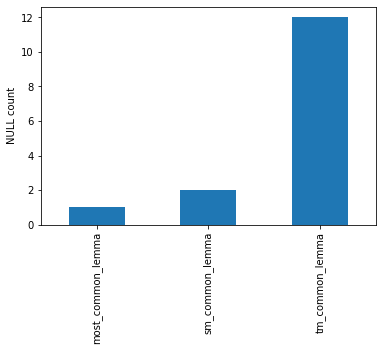

In [34]:
df[['most_common_lemma', 'sm_common_lemma', 'tm_common_lemma']].isnull().sum().plot(kind='bar', ylabel='NULL count')

holy whores have thouroughly fucked my plans! curses! dangit dangit twice!!
<br> thats the only film with no common lemmas at all at least. Minimal without all three is also probs a good thing. 

next I'll do something with that 'category' column, first thought is to added a filtered_category column that will replace all lemmas in 'filtered_lemmas' with their matched category. it might then also be a good idea to find the most common categories of each film (still go with top 3?), and repeat fill the most popular in cases where there aren't three separate ideas.

In [35]:
def replace_lemmas_with_category(
    filtered_lemmas,
    category_df,
):
    """Replace all elements in a list with a mapped value where appropriate. Remove them from the list if not.
    
    Parameters
    ----------
    filtered_lemmas : string
        Comma separated string of lemmas.
    category_df : pd.DataFrame
        Dataframe containing a 'lemma' and 'category' column to act as a map.
        
    Returns
    -------
    string
        Comma separated string of mapped categories.
    """
    filtered_lemmas = filtered_lemmas.replace(' ', '').split(',')
    filtered_lemmas = pd.DataFrame(filtered_lemmas, columns=['lemma'])
    
    filtered_lemmas = pd.merge(filtered_lemmas, category_df, on='lemma', how='left')
    
    lemma_categories = ', '.join(filtered_lemmas.category.dropna().tolist())
    
    return lemma_categories


def most_popular_category(
    categories,
    depth,
):
    """Find the most popular category in a given list.
    
    Parameters
    ----------
    categories : string
        Comma separated list of available categories.
    depth : int
        Which most popular category will you go with, assuming one exists.
        
    Returns
    -------
    string
        The most popular category.
    """
    categories = categories.replace(' ', '').split(',')
    categories = pd.Series(Counter(categories))  # creates a series of value counts
    
    if depth in range(len(categories)):
        return categories.sort_values(ascending=False).index[depth]
    
    elif len(categories) > 0:
        return categories.sort_values(ascending=False).index[0]
    
    else:
        return 'Unknown'
    

df['filtered_lemma_cats'] =  df.apply(lambda x: replace_lemmas_with_category(x['filtered_lemmas'], lemma_counts), axis=1)
df['most_frequent_category'] = df.apply(lambda x: most_popular_category(x['filtered_lemma_cats'], 0), axis=1)
df['sm_frequent_category'] = df.apply(lambda x: most_popular_category(x['filtered_lemma_cats'], 1), axis=1)
df['tm_frequent_category'] = df.apply(lambda x: most_popular_category(x['filtered_lemma_cats'], 2), axis=1)

df[['filtered_lemmas', 'filtered_lemma_cats', 'most_frequent_category', 'sm_frequent_category', 'tm_frequent_category']]

,filtered_lemmas,filtered_lemma_cats,most_frequent_category,sm_frequent_category,tm_frequent_category
0,"money, sex, fashion, city, love, war, legendar...","money, sex, fashion, urban, romantic, war, cla...",international,romantic,sex
1,"shoot, western, train, prison, mission, game, ...","action, western, journey, crime, spy, action, ...",action,political,thriller
2,"autobiographical, heart, war, ii, postwar, fra...","documentary, emotional, war, war, war, interna...",war,emotional,tragedy
3,"hollywood, revolutionary, series, melodrama, w...","classic, political, series, drama, female, war...",characterstudy,romantic,international
4,"york, influential, drama, hollywood, silent, d...","urban, classic, drama, classic, silent, crime,...",crime,political,classic
...,...,...,...,...,...
1436,"french, international, art, independent, perso...","international, international, arthouse, arthou...",arthouse,characterstudy,political
1437,"czech, action, postwar, legend, fantasy, adven...","international, action, war, classic, fantasy, ...",adventure,international,period
1438,"giant, italian, poetry, neorealism, dream, mem...","monster, international, arthouse, arthouse, ar...",arthouse,fantasy,horror
1439,"culture, martial, art, hong, kong, hollywood, ...","political, fighting, arthouse, international, ...",international,arthouse,action


**Word Cloud**

I'll get a feel for how well this matching went by creating a very simple word cloud graphic for the categories and seeing what I can glean from it. I'm assuming the largest words will all be the most generic whilst the smaller ones will be legitimate genres but it could depend on how clumsy I was with my initial assignment of the categories

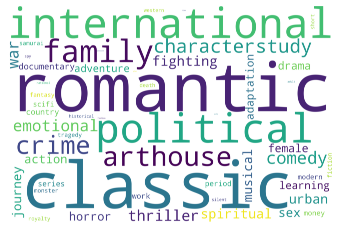

In [20]:
text = []
cols_to_fiddle = ['most_frequent_category', 'sm_frequent_category', 'tm_frequent_category']

for col in cols_to_fiddle:
    text += df[col].dropna().tolist()
text = ' '.join(text)

wordcloud = WordCloud(width = 6000, height = 4000, random_state=1, background_color='white',
                      colormap='viridis', collocations=False).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

I'm going to get a bit experimental here, and plot a graph network connecting the first, second and third most common lemmas.

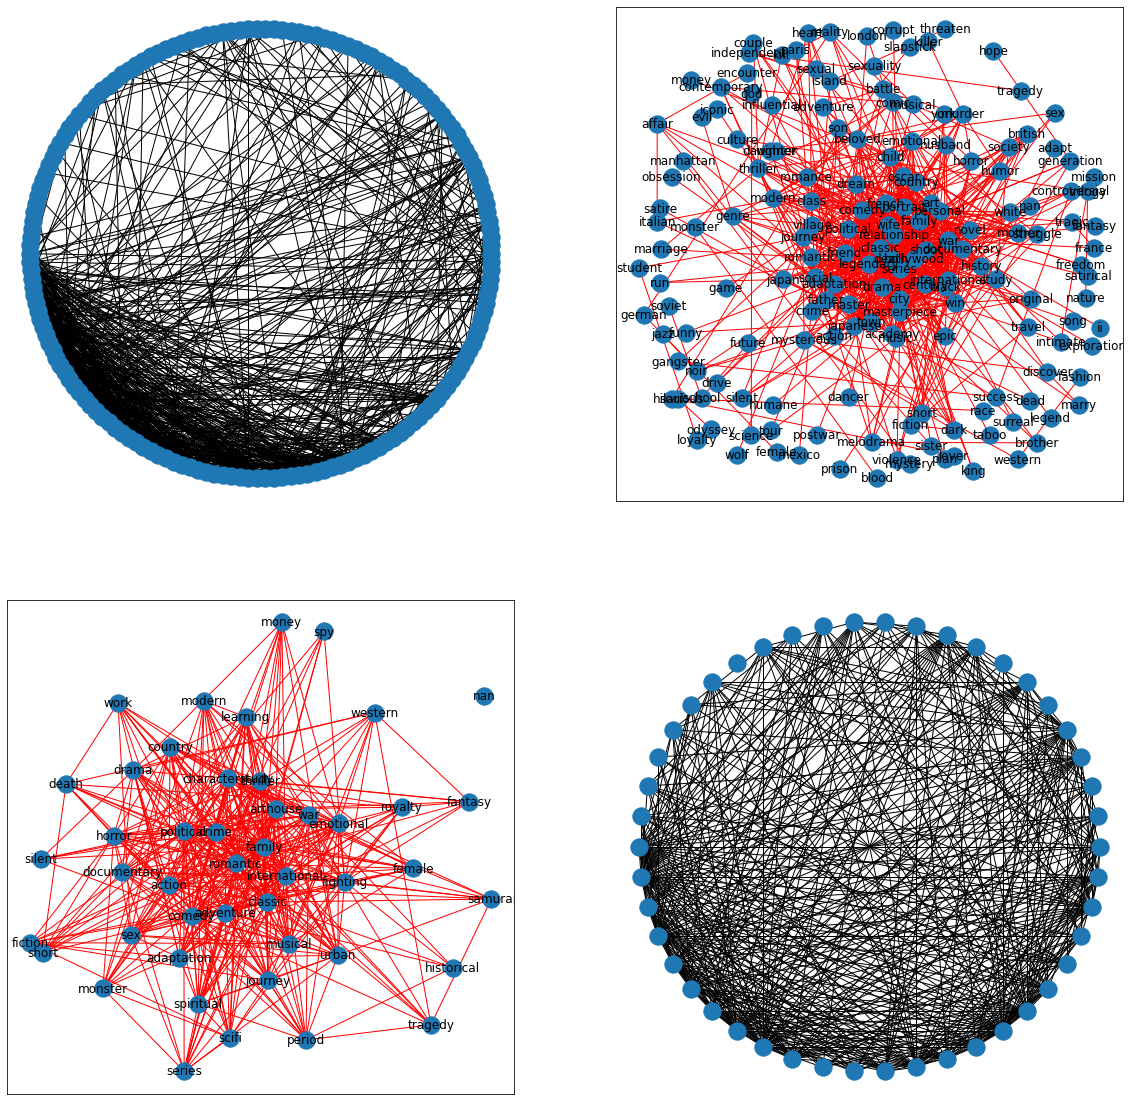

In [4]:
G1 = nx.Graph()
G1 = nx.from_pandas_edgelist(df, 'most_common_lemma', 'sm_common_lemma', 'tm_common_lemma')

G2 = nx.Graph()
G2 = nx.from_pandas_edgelist(df, 'most_frequent_category', 'sm_frequent_category', 'tm_frequent_category')

fig, ax = plt.subplots(2, 2, figsize=(20, 20))

nx.draw_shell(G1, with_labels=False, ax=ax[0, 0])
nx.draw_networkx(G1, pos=nx.spring_layout(G1, k=0.5, iterations=20), ax=ax[0, 1], edge_color='r')
nx.draw_shell(G2, with_labels=False, ax=ax[1, 1])
nx.draw_networkx(G2, pos=nx.spring_layout(G2, k=0.8, iterations=20), ax=ax[1, 0], edge_color='r')

I started with a shell layout just to see what it did, and yeah not the most readable. We can deffo see words that are more or less connected so prehaps there are some more natural 'clusters' so to speak. Unfortunatly, the second graph is a bit hard to read on its own, some of the less tighed up words can be clearly read and seem to make sense as being linked to one another at least. An interesting one is that God and science are a two word cluster, which yeah i guess makes sense as kind of opposites. I think to get real meaning out of this we'll have to actually start breaking apart the graph network to some extent.

the second row of graphs is done after I classified the popular lemmas into categories and is a bit more readable, but more importantly is likely to have created a more useable graph for further analysis.

I'd like to quickly get a sense of what the most linked words are - I believe that these arent *necessarily* the most frequent words (though I wouldnt be suprised if they were) but rather the words most likely to relate to subgenre rather than genre.

In [5]:
lemma_links = {}

for lemma in G2.nodes:
    lemma_links[lemma] = len(G2[lemma])
    
lemma_links = pd.Series(lemma_links, name='number_of_links').to_frame().sort_values('number_of_links', ascending=False)

lemma_links

,number_of_links
romantic,38
classic,37
family,37
international,36
political,36
arthouse,34
crime,33
comedy,30
thriller,29
characterstudy,28


Yeah I can see that - alot of films will have a romantic sub plot, whilst 'classic' by this time covers like almost a half of the totla films I think and 'family' was just for use of familial words so probably doesn't tell us too much. In other words the most popular link words are the ones most likely to apply to aspects of the film rather than its overall genre. Interesting to see the most linked words are also the most popular. Who could've seen that twist coming not this guy nuh-uh

I think some interesting ideas here could be as follows:
- create a tree hierarchy of the labelled lemmas and see how things behave within that. This might require more grit in some areas, but could be used as a classification tool to see how many categories under a certain subheading a given group hits?
- create a new graph with weighted vertices based on number of times two words are paired and see what we can learn from that.

so next step I'll try is weighting then?

In [52]:
col1 =  np.concatenate([df.most_frequent_category.values,
                         df.most_frequent_category.values,
                         df.sm_frequent_category.values])
col2 = np.concatenate([df.sm_frequent_category.values,
                       df.tm_frequent_category.values,
                       df.tm_frequent_category.values])

pairs_df = pd.DataFrame(col1, col2).reset_index()
pairs_df.columns = ['pair1', 'pair2']

pairG = nx.from_pandas_edgelist(pairs_df, 'pair1', 'pair2', create_using=nx.MultiGraph())
lemmas = list(lemma_links.index)

for lemma1 in lemmas:
    for lemma2 in lemmas:
        if lemma1 != lemma2:
            try:
                G2[lemma1][lemma2]['weight'] = pairG.number_of_edges(lemma1, lemma2)
            except KeyError:
                pass

# so we've now weighted the graph correctly...  what next though lol

In [38]:
df.to_csv('data/criterion_cleaned.csv', index=False)

In [3]:
df = pd.read_csv('data/criterion_cleaned.csv')